# V02 Preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import plotly.express as px
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.trend import PolynomialTrendForecaster
import warnings
import ruptures as rpt


os.chdir("/home/cernerrood246/University/DataMining")
pd.set_option("display.precision", 2)

## Study Meta Data

In [ ]:
study_meta_data_df = pd.read_csv("original_dataset/Study_Information.csv")
study_meta_data_df

In [ ]:
study_meta_data_df.select_dtypes(include=np.number).corr()


-> Cycle 2 doesn't correlate with effort, in general estimations don't seem great and are in 5 minute intervals which makes them kinda unusable

In [ ]:
demographics_df = pd.read_csv("original_dataset/Demographics.csv")
demographics_df

## Preprocess

### Analysis

In [ ]:
for participant_df in VO2_all_list:
    print(participant_df.isnull().sum())

=> Very few null values, should be fine just to fill them and ignore

In [ ]:
for participant_df in VO2_all_list:
    print((participant_df["Time[s]"].diff() <= -1)[1:].any())
    if (participant_df["Time[s]"].diff() <= -1)[1:].any():
        print(participant_df[(participant_df["Time[s]"].diff() <= -1)]) 

=> Some seconds are duplicated / some are missing

### Time formating + Outlier Detection + Fill missing Values

In [ ]:
#study_meta_data_df = pd.read_csv("original_dataset/Study_Information.csv")
participants_list = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
VO2_all_list = [pd.read_csv(f"original_dataset/{participant}/VO2/DataAverage.csv") for participant in participants_list]

In [ ]:
drop_dict=dict([(2,1), (3,1), (6,3), (9,4), (12,2), (14,2), (15,4), (16,3)])
drop_timestamp_dict = {}
for i,participant_df in enumerate(VO2_all_list):
    temp_participant_df = participant_df.copy().fillna(0)
    algo = rpt.Pelt(model="rbf", min_size = 250).fit(temp_participant_df["VO2[mL/kg/min]"].values)
    result = algo.predict(pen=10)
    if i+1 in drop_dict.keys():
        drop_timestamp_dict[i+1] = (temp_participant_df["Time"].iloc[result[drop_dict[i+1]-1]], temp_participant_df["Time"].iloc[result[drop_dict[i+1]]-1])
    ax = temp_participant_df.plot(y = "VO2[mL/kg/min]", title=f"Participant {i+1}")
    #add x axis name "Time[s]"
    ax.set_xlabel("Time[s]")
    for line in result:
        ax.axvline(line, color='r', linestyle='--')


    #plt.show()

In [ ]:
V02_all_preprocessed_list = []

for p_number ,participant_df in enumerate(VO2_all_list):
    print(f"Participant {p_number+1}")
    temp_participant_df = participant_df.copy()


    temp_participant_df = temp_participant_df.drop(columns=["Time[hh:mm:ss]"])

    
    start_timestamp = pd.to_datetime(temp_participant_df["Time"].loc[0],format='%Y-%m-%d %H:%M:%S')
    temp_participant_df["Delta_Time"] = pd.to_datetime(temp_participant_df["Time"], format='%Y-%m-%d %H:%M:%S') - start_timestamp
    temp_participant_df["Time"] = pd.to_datetime(temp_participant_df["Time"], format='%Y-%m-%d %H:%M:%S')
    
    temp_participant_df = temp_participant_df.groupby("Time").mean()
    temp_participant_df = temp_participant_df.dropna(thresh = 6)
    temp_participant_df = temp_participant_df.asfreq("s")
    temp_participant_df["Time[s]"] = np.arange(1, len(temp_participant_df) + 1)
    
    
    #temp_participant_df = temp_participant_df[temp_participant_df["Time[s]"] <= 1800]

    #print(participant_df["Time[s]"].max())
    print(f"    number of zeros: {(temp_participant_df['VO2[mL/kg/min]'] == 0).sum()}")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Series contains nan values")
        transformer = HampelFilter(window_length=30, n_sigma=2, return_bool = False)
        y_hat = transformer.fit_transform(temp_participant_df["VO2[mL/kg/min]"].values)
    #calculat number of nans in y_hat
    print(f"    number of identified outliers:{np.isnan(y_hat).sum()}")
    forecaster = PolynomialTrendForecaster(degree=2)
    transformer = Imputer(forecaster=forecaster)
    for i in range(int(np.ceil(y_hat.shape[0] / 300))):
        if (i+1)*300 > y_hat.shape[0]:
            try: 
                y_hat[i*300:] = transformer.fit_transform(y_hat[i*300:])
            except:
                y_hat[i*300:] = np.zeros(shape = y_hat[i*300:].shape)
        else: 
            try:
                y_hat[i*300:(i+1)*300] = transformer.fit_transform(y_hat[i*300:(i+1)*300])
            except:
                y_hat[i*300:(i+1)*300] = np.zeros(shape = y_hat[i*300:(i+1)*300].shape)
    temp_participant_df["VO2[mL/kg/min_filtered]"] = y_hat
    
    temp_participant_df[["VO2[mL/kg/min]", "VO2[mL/kg/min_filtered]", "Time[s]"]].plot(x = "Time[s]", title=f"Participant {p_number+1}")

    V02_all_preprocessed_list.append(temp_participant_df)
    

    

### Rolling Window + Convert to MET

In [ ]:
V02_all_converted_list = []
for i, participant_df in enumerate(V02_all_preprocessed_list):
    temp_participant_df = participant_df.copy()
    temp_timedelta = temp_participant_df["Delta_Time"]
    temp_participant_df = temp_participant_df.drop(columns=["Delta_Time"])
    last = lambda x: x.iloc[-1]
    temp_participant_df = temp_participant_df.rolling(5, min_periods = 1).agg({'Time[s]':last,
                                                                'VO2[mL/kg/min]':"mean", 
                                                                'VO2[mL/min]':"mean", 
                                                                'HR[bpm]':"mean", 
                                                                'Rf[bpm]':"mean",
                                                                'Tv[L]':"mean", 
                                                                'Ve[L/min]':"mean", 
                                                                'Ve/VO2':"mean", 
                                                                'FeO2[%]':"mean", 
                                                                'Pressure[hPa]':"mean", 
                                                                'Temp[C]':"mean",
                                                                'HUM[%RH]':"mean", 
                                                                'RR[ms]':"mean", 
                                                                #'Delta_Time':first, 
                                                                'VO2[mL/kg/min_filtered]':"mean",
                                                                })
    temp_participant_df["Delta_Time"] = temp_timedelta
    temp_participant_df["MET"] = temp_participant_df["VO2[mL/kg/min_filtered]"] / 3.5
    #temp_participant_df.plot(x="Delta_Time", y="VO2[mL/kg/min_filtered]", title=f"Participant {i+1}")
    V02_all_converted_list.append(temp_participant_df)


In [ ]:
#plot V02 before and after converting

for i, dfs in enumerate(zip(V02_all_preprocessed_list, V02_all_converted_list)):
    
    plt.plot(dfs[0]["Time[s]"], dfs[0]["VO2[mL/kg/min_filtered]"] / 3.5, label="MET: Original")
    plt.plot(dfs[1]["Time[s]"], dfs[1]["VO2[mL/kg/min_filtered]"] / 3.5, label="MET: After Window")
    plt.title(f"Participant {i+1}")
    plt.xlabel("Time[s]")
    plt.legend()
    plt.show()

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


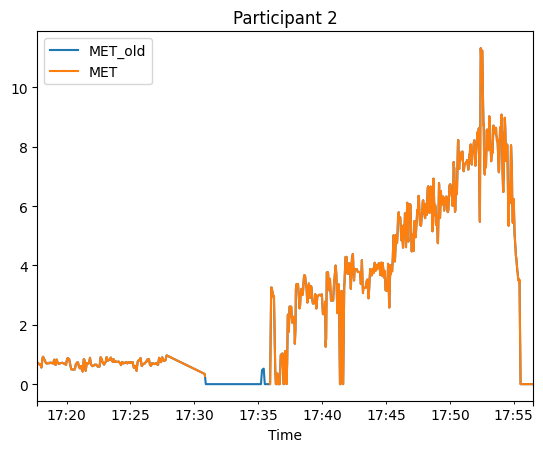

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


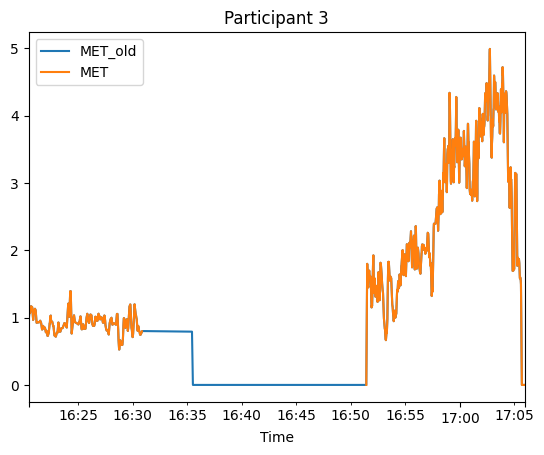

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


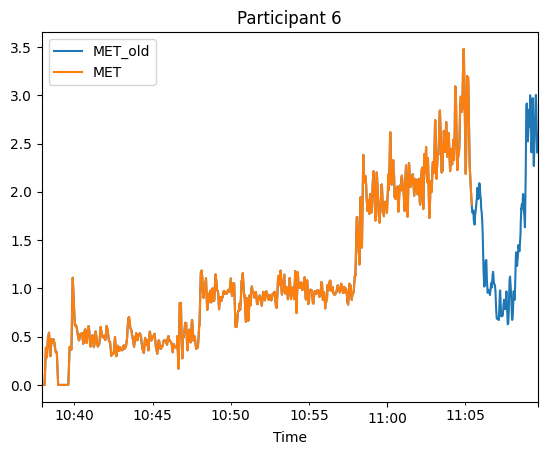

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


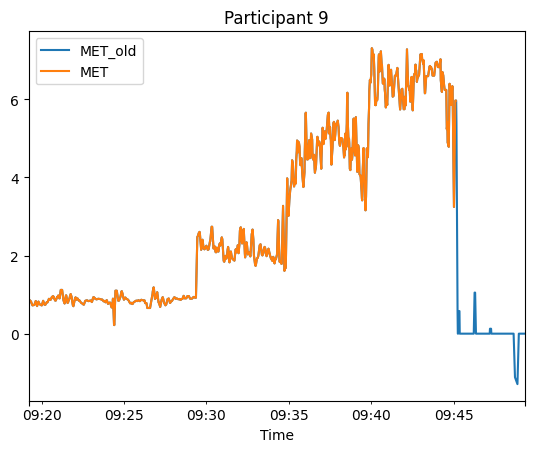

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


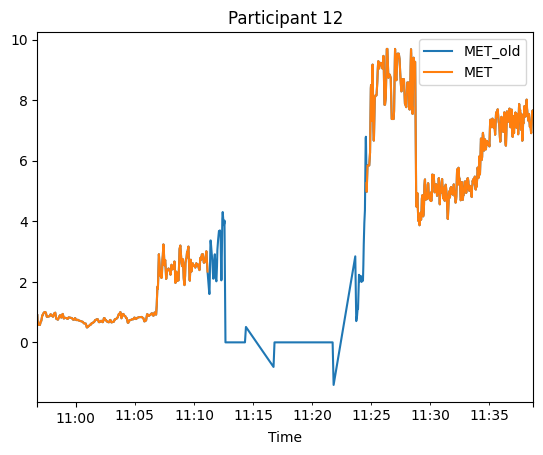

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


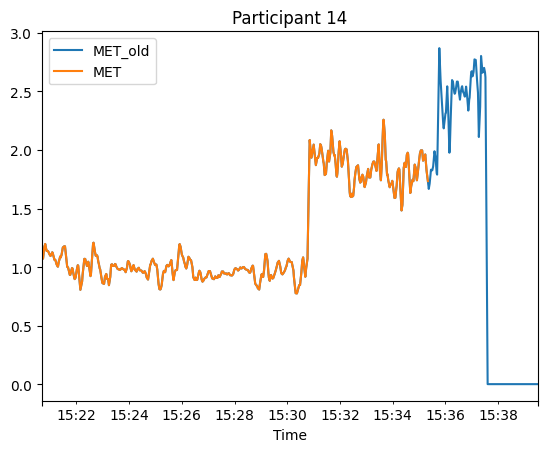

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


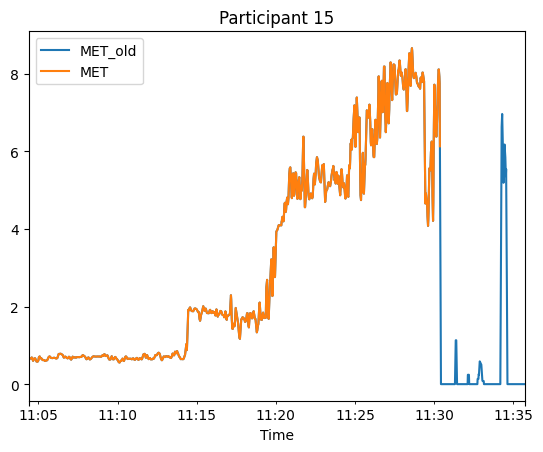

/tmp/ipykernel_3332/2555995343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_participant_df["MET"][mask] = np.nan


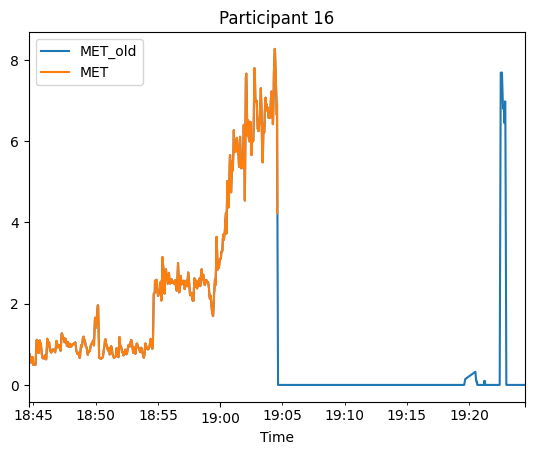

In [13]:
V02_all_converted_dropped_list = []
for i, participant_df in enumerate(V02_all_converted_list):
    temp_participant_df = participant_df.copy()
    
    if i+1 in drop_timestamp_dict.keys():
        start_date = pd.to_datetime(drop_timestamp_dict[i+1][0], format='%Y-%m-%d %H:%M:%S')
        end_date = pd.to_datetime(drop_timestamp_dict[i+1][1], format='%Y-%m-%d %H:%M:%S')
        mask = (temp_participant_df.index >= start_date) & (temp_participant_df.index < end_date)
        temp_participant_df["MET_old"] = temp_participant_df["MET"]
        temp_participant_df["MET"][mask] = np.nan
        temp_participant_df[["MET_old", "MET"]].plot(title=f"Participant {i+1}")
        plt.show()
        temp_participant_df.drop(columns=["MET_old"], inplace=True)
        #coums where MET is not nan
        temp_participant_df = temp_participant_df[temp_participant_df['MET'].notna()]
        
    V02_all_converted_dropped_list.append(temp_participant_df)


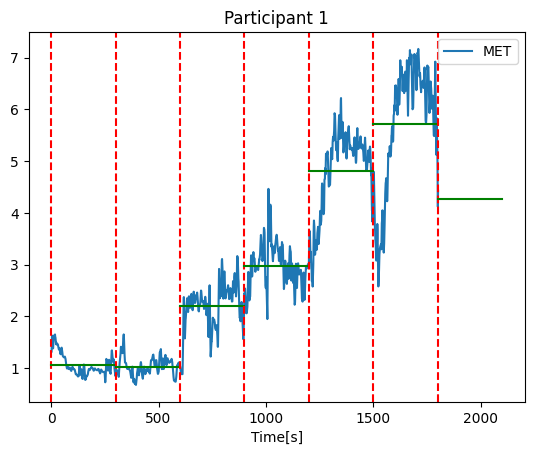

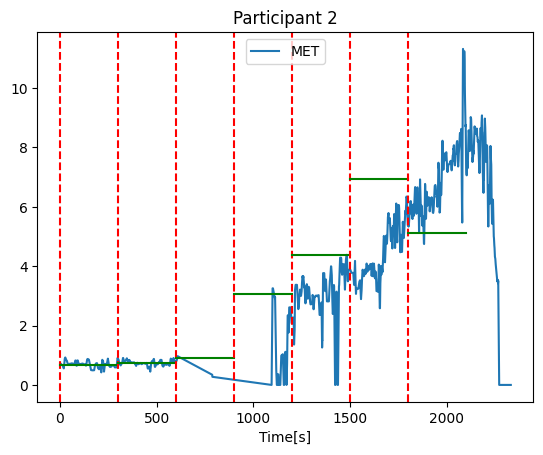

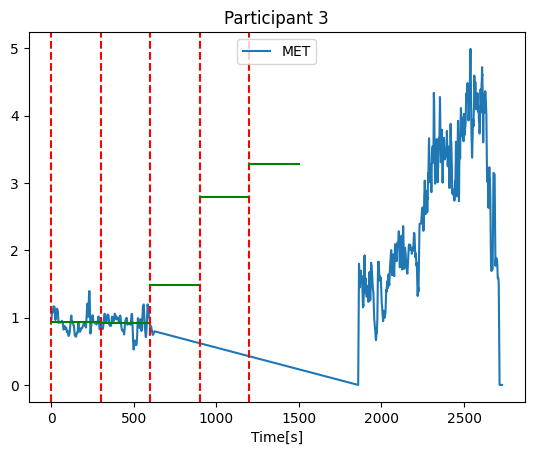

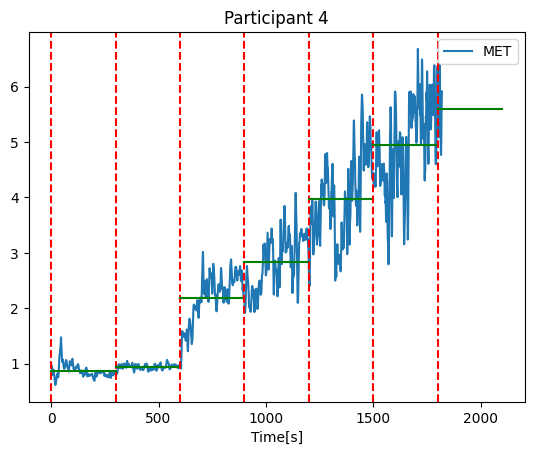

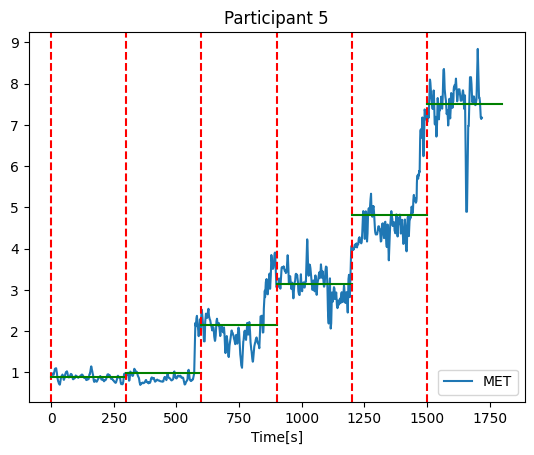

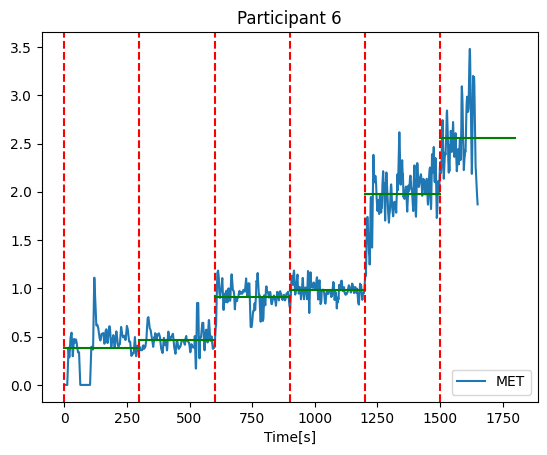

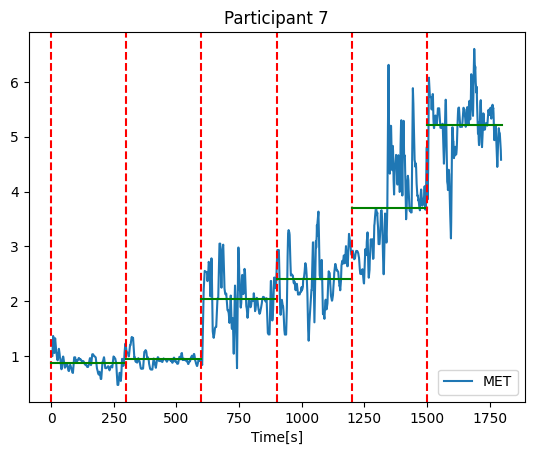

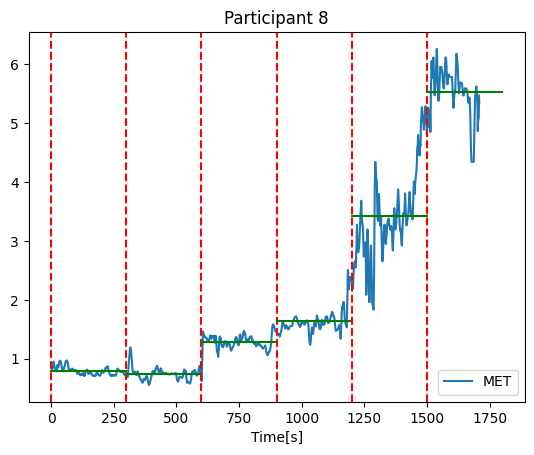

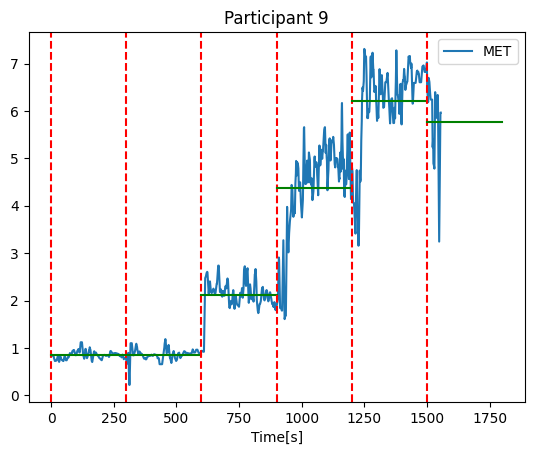

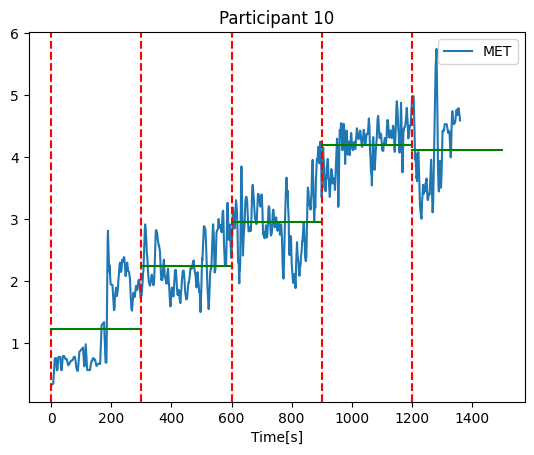

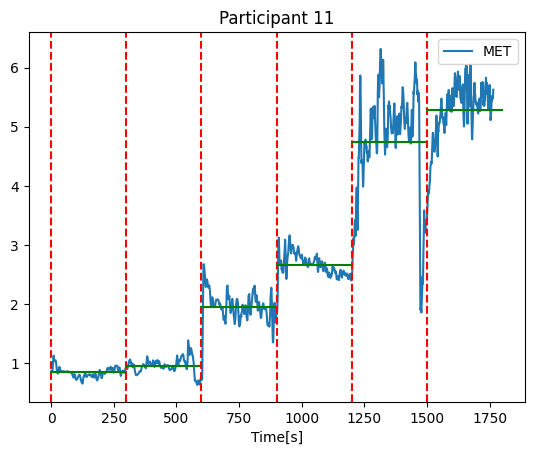

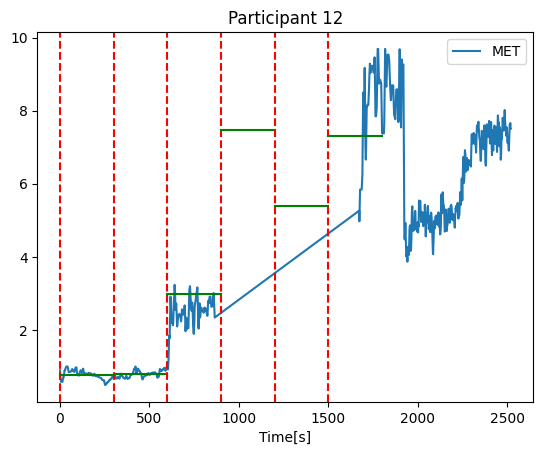

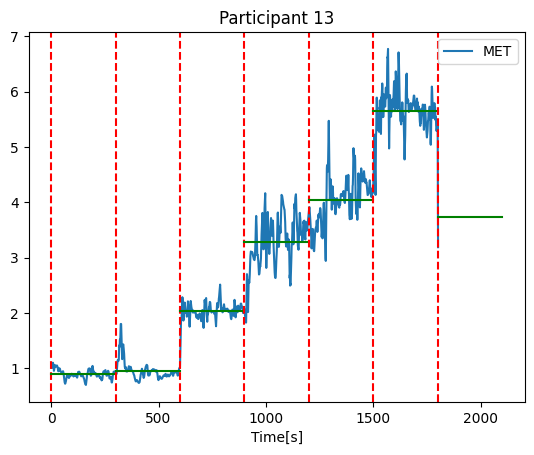

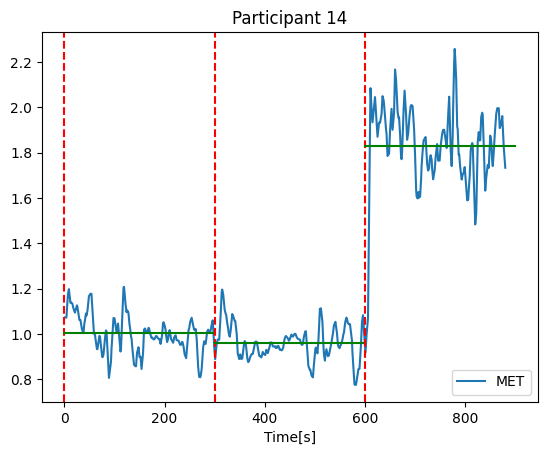

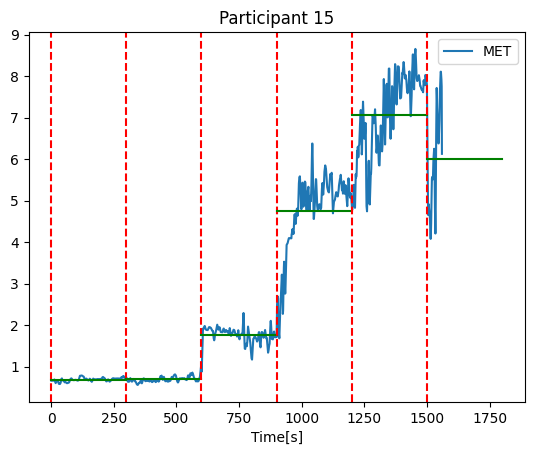

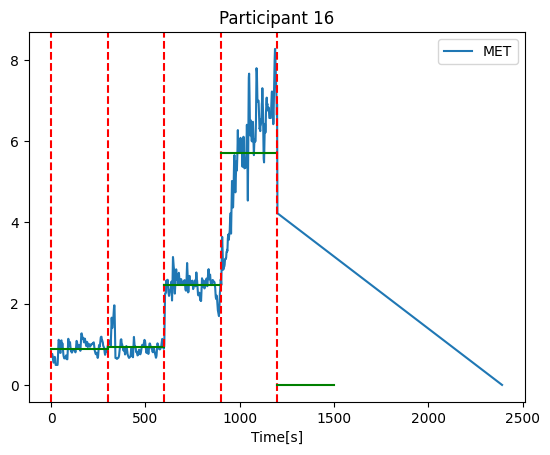

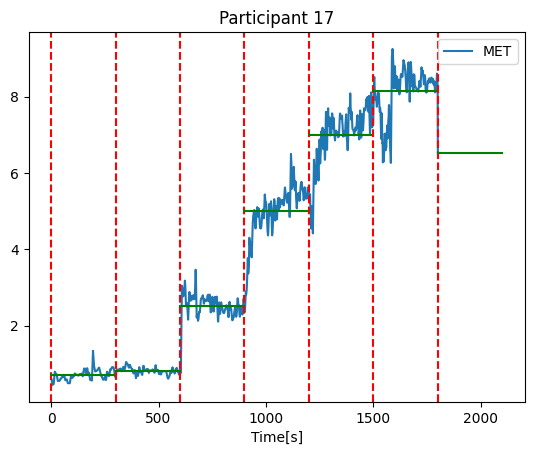

In [14]:
for i, participant_df in enumerate(V02_all_converted_dropped_list):
    #x should be Delta_Time
    #participant_df.plot(x = "Delta_Time",y = "MET", title=f"Participant {i+1}")
    
    ax = participant_df.plot(x = "Time[s]",y = "MET", title=f"Participant {i+1}")
    for i in range(0, len(participant_df), 300):
        ax.axvline(i, color='r', linestyle='--')
        mean = participant_df["MET"].iloc[i:i+300].mean()
        plt.plot([i,i+300],[mean, mean], color='g', linestyle='-')

    plt.show()
    

### Save Preprocessed Data

In [ ]:
participant_df[['Time[s]','Delta_Time', 'MET']]

In [15]:
for i, participant_df in enumerate(V02_all_converted_dropped_list):
    os.makedirs(f"preprocessed_dataset/P{i+1}", exist_ok=True)
    #participant_df[['Time[s]','Delta_Time', 'MET']].to_csv(f"preprocessed_dataset/P{i+1}/MET.csv")
    participant_df[['Time[s]','Delta_Time', 'MET']].to_pickle(f"preprocessed_dataset/P{i+1}/MET.pkl")
    #os.remove(f"preprocessed_dataset/P{i+1}/MET.csv")
    